## Extinction calculation

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm      
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from radmcutils import *

### Read in model

In [3]:
model = Radmc3dModel()
model.read_grid(dir='50au/ori/')
model.read_file('dust_density.binp')
model.read_file('dust_temperature.bdat')
print(model.amrinfo)
nx, ny = model.nx[0], model.ny[0]

[[  0  35  34 311  60  34  60]
 [  1  31   4  31  60  62  60]
 [  2  31  20  31  60  86  60]
 [  3  31  44  31  60  86  60]]


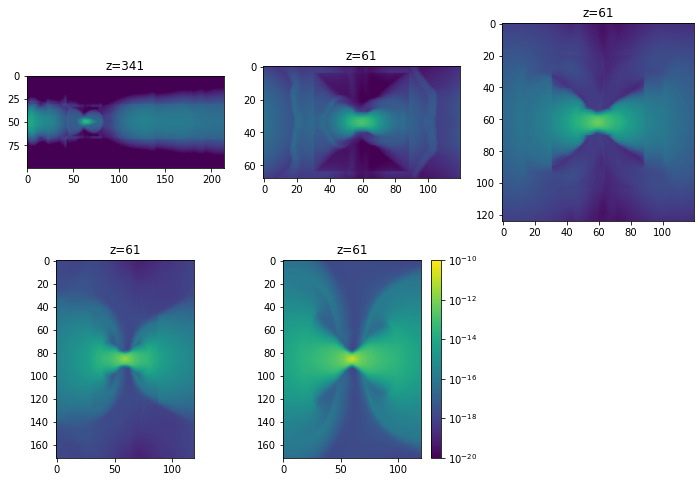

In [4]:
# ------- Plot density slices -------
cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))

plt.figure(figsize=(12,8))
for i in range(model.nrlayers):
    plt.subplot(2,3,i+1)
    zindex = int(model.nz[i]/2) + 1
    plt.imshow(model.dust_dens[i][:,:,zindex].T,cmap=cmap, norm=LogNorm(vmin=1e-20, vmax=1e-10))
    plt.title("z="+str(zindex))
plt.colorbar()

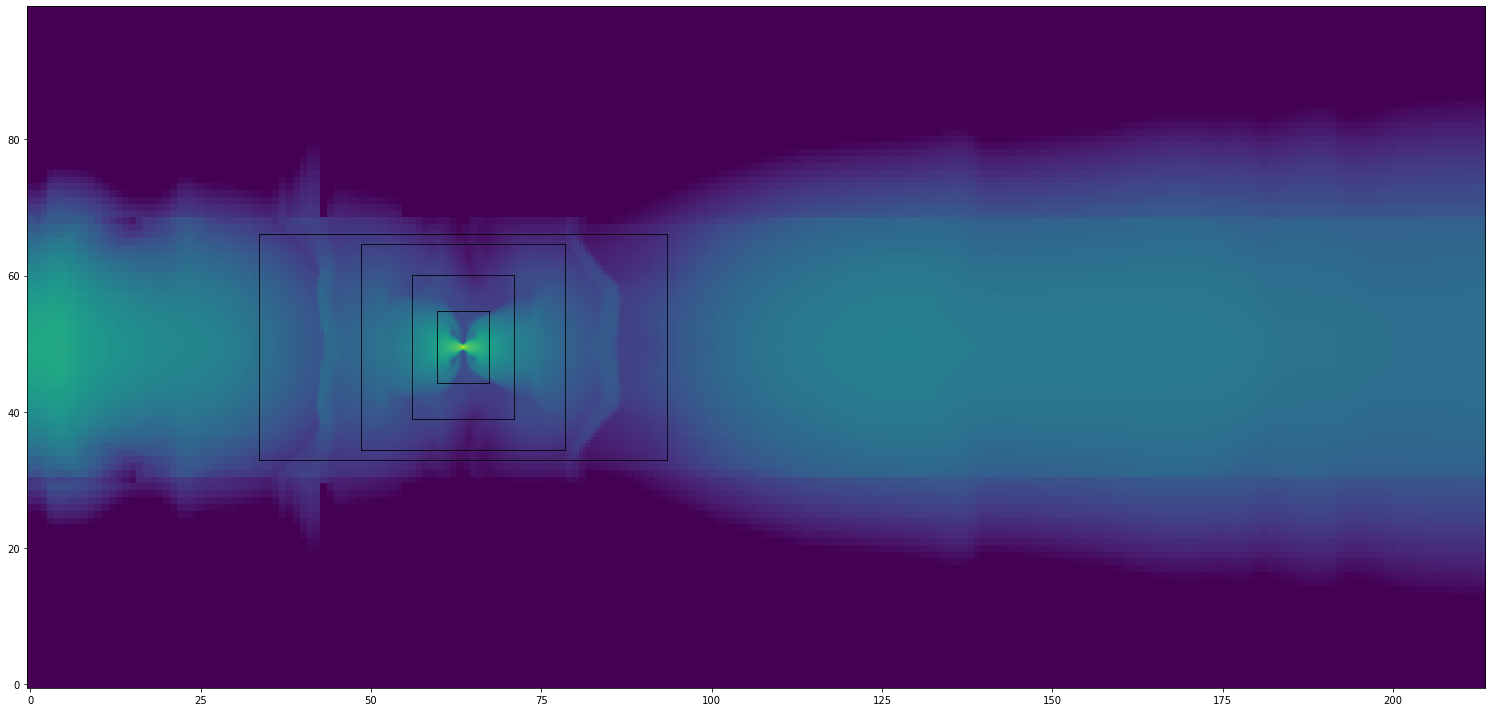

In [5]:
# plot all amr layers together
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def incl_amr(model, field=model.dust_dens, vmin=1e-20, vmax=1e-10, axis=True):
    # inset axes....
    for i in range(model.nrlayers-1):
        if i == 0:
            xmin = (model.amrinfo[0][1]-1)/nx 
            ymin = (model.amrinfo[0][2]-1)/ny
            xlen = model.amrinfo[0][4]/nx 
            ylen = model.amrinfo[0][5]/ny 
        else: 
            t1 = xlen * (model.amrinfo[i][1]-1)/(2*model.amrinfo[i-1][4])
            t2 = ylen * (model.amrinfo[i][2]-1)/(2*model.amrinfo[i-1][5])
            xmin += t1
            ymin += t2
            xlen *= model.amrinfo[i][4]/(model.amrinfo[i-1][4]*2)
            ylen *= model.amrinfo[i][5]/(model.amrinfo[i-1][5]*2)
        bound = [xmin, ymin, xlen, ylen]

        axins = ax.inset_axes(bound)
        extent = (0, model.amrinfo[i][4]*2, 0, model.amrinfo[i][5]*2)
        z = int(model.nz[i+1]/2) + 1
        axins.imshow(field[i+1][:,:,z].T, extent=extent, origin="lower", 
                    norm=LogNorm(vmin=vmin, vmax=vmax))
        if axis == False:
            axins.axis('off')
        else:
            axins.xaxis.set_ticklabels([])
            axins.xaxis.set_ticks_position('none')
            axins.yaxis.set_ticklabels([])
            axins.yaxis.set_ticks_position('none')

# density plot
fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
z = int(model.nz[0]/2) + 1
ax.imshow(model.dust_dens[0][:,:,z].T, origin="lower", norm=LogNorm(vmin=1e-20, vmax=1e-10))
incl_amr(model)

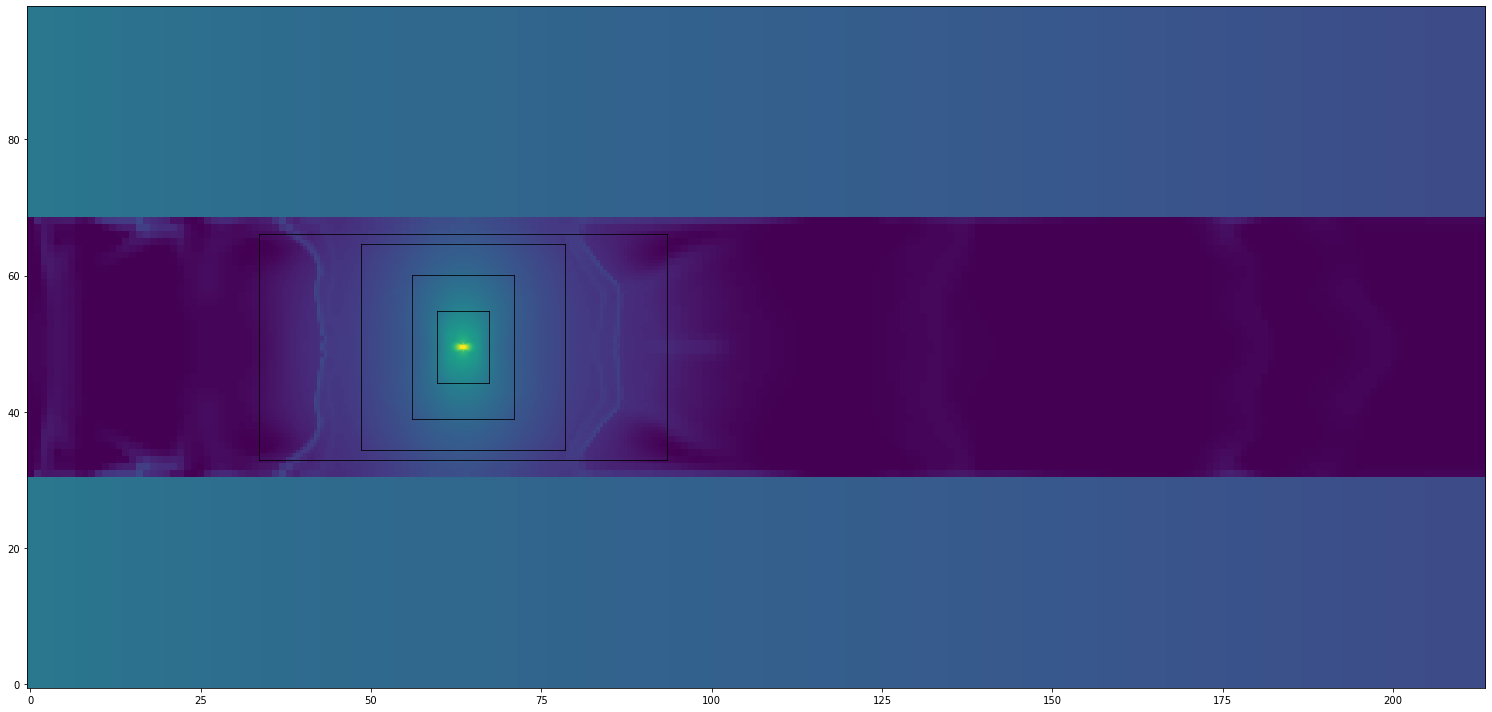

In [6]:
# temperature plot
fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
im = ax.imshow(model.dust_temp[0][:,:,341].T, origin="lower", norm=LogNorm(vmin=10, vmax=1e3))
incl_amr(model, model.dust_temp, vmin=10, vmax=1e3, axis=True)

### Define CPD and planet surface

In [7]:
# estimate Hill radius
from astropy.constants import *
import astropy.units as u
m = 10 * M_jup   # planet mass
M = M_sun        # stellar mass
a = 50 * u.AU      # planet orbital radius
r_hill = a * (m/(3*M))**(1/3)
print("Hill radius of planet is", r_hill)

Hill radius of planet is 7.354207087398273 AU


In [104]:
# determine planet position and size
xmin = (model.ix[0]*u.cm).to(u.AU)
xmax = (model.ix[-1]*u.cm).to(u.AU)
AU2cellnr = nx / (xmax - xmin)
x_pl = int(AU2cellnr * (a - xmin))
y_pl = int(ny/2)
size_pl = 1   #TODO: justify size_pl?
ori_pl = (x_pl - size_pl/2 - 0.5, y_pl - size_pl/2 - 0.5)
print('One cell in x-axis corresponds to', 1/AU2cellnr)

One cell in x-axis corresponds to 0.46155293605123576 AU


In [10]:
# determine CPD position and size
iy_CPD = np.pi/2 - np.arctan(r_hill / 4 / a).value
rad2cellnr = ny / (model.iy[-1]-model.iy[0])
y_CPD = int(rad2cellnr * (iy_CPD - model.iy[0]))
sizey_CPD = int(rad2cellnr * 2 * np.arctan(r_hill / 4 / a).value)
sizex_CPD = int(AU2cellnr * r_hill)
ori_CPD = (x_pl - sizex_CPD/2 - 0.5, y_CPD)   # TODO:this seems the better definition in y-direction
#ori_CPD2 = (x_pl - sizex_CPD/2 - 0.5, y_pl - size_CPD2/2 - 0.5) 
ori_CPD, sizex_CPD, sizey_CPD

((56.0, 44), 15, 11)

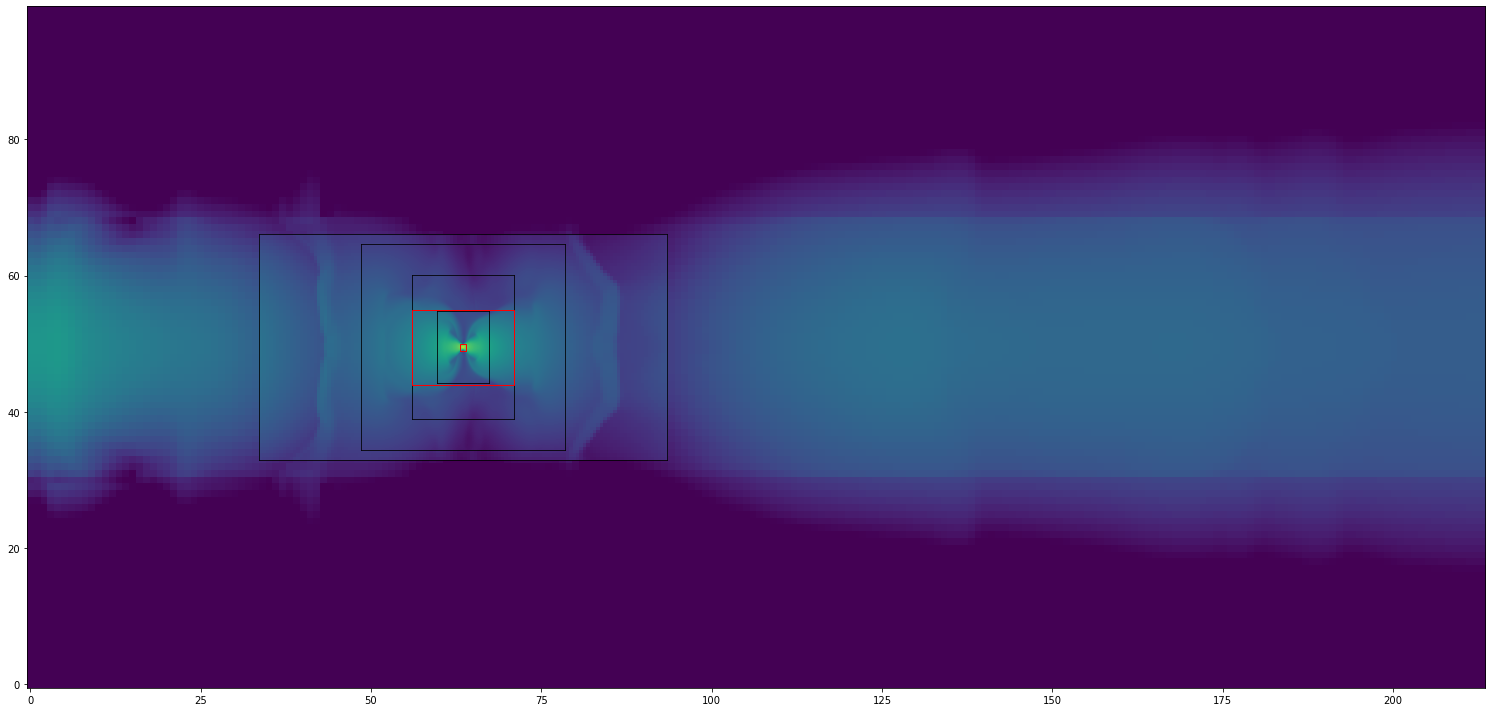

In [11]:
# mark planet & CPD region on density plot
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
z = int(model.nz[0]/2) + 1
im = ax.imshow(model.dust_dens[0][:,:,z].T, origin="lower", norm=LogNorm(vmin=5e-20, vmax=5e-10))
#fig.colorbar(im, ax=ax, fraction=0.022)
incl_amr(model, axis=True)

# plot planet
rec_pl = patches.Rectangle(ori_pl,size_pl,size_pl,linewidth=1,edgecolor='r',facecolor='none', zorder=10)
ax.add_patch(rec_pl)

# plot CPD
rec_CPD = patches.Rectangle(ori_CPD,sizex_CPD,sizey_CPD,linewidth=1,edgecolor='r',facecolor='none', zorder=10)
ax.add_patch(rec_CPD)

### Cases for extinction value

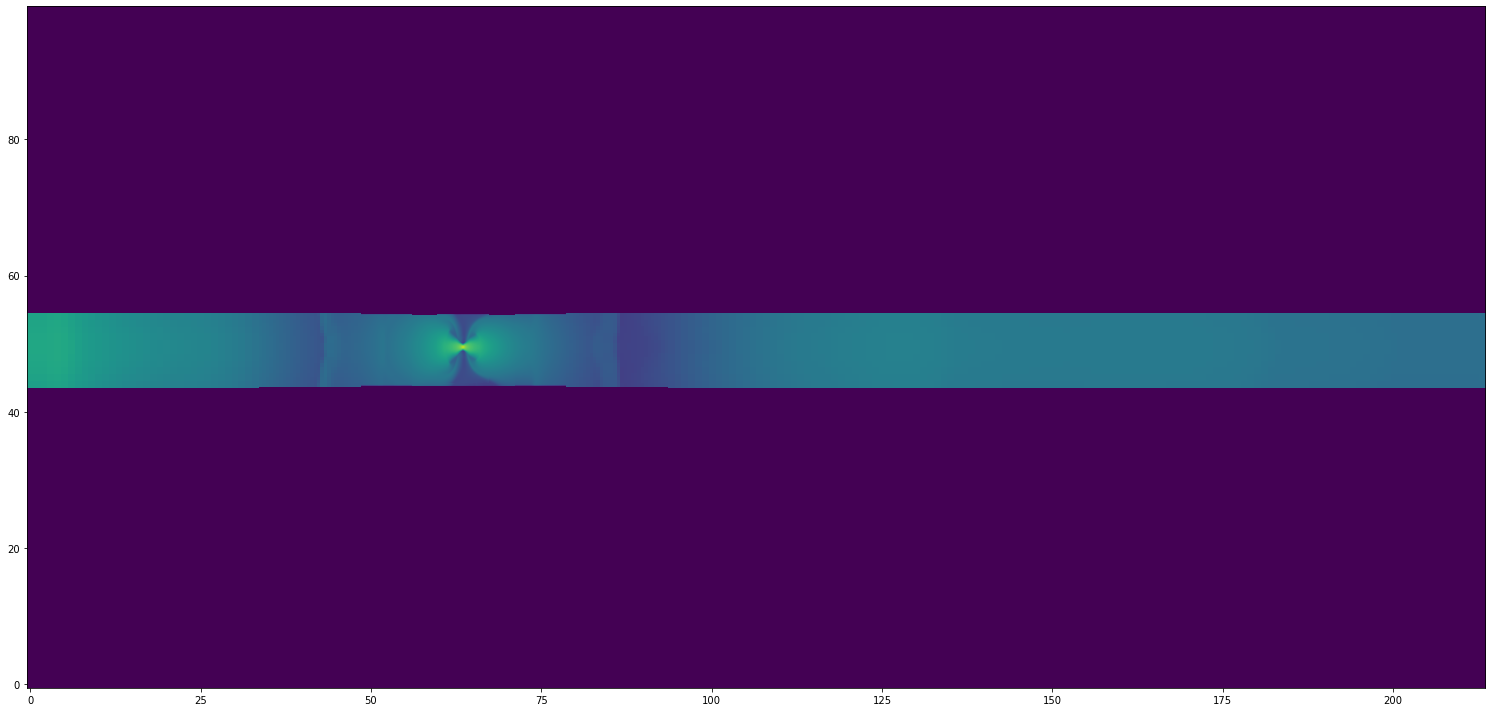

In [12]:
def get_y_coord(y0, parentid, model=model):
    if parentid == 0:
        return int(2 * (y0 - model.amrinfo[parentid][2] +1))
    else:
        return int(2 * (get_y_coord(y0, parentid-1) - model.amrinfo[parentid][2] +1))

def set_zero(y0, ysize, offset=0, fieldname='dust_dens', model=model):
    if fieldname == 'dust_dens':
        field = model.dust_dens
    else:
        field = model.dust_temp
    fieldnew = [np.zeros((field[0].shape))]
    fieldnew[0][:,y0:y0+ysize,:] = field[0][:,y0:y0+ysize,:]
    offset1 = 0
    for i in range(1, model.nrlayers):
        fieldnew.append(np.zeros((field[i].shape)))
        ymin = get_y_coord(y0+offset, i-1) + offset1
        size = 2**(i) * ysize -2*offset1
        offset1 += 1
        if ymin < 0:
            fieldnew[i][:,0:ymin+size,:] = field[i][:,0:ymin+size,:]
        else:
            fieldnew[i][:,ymin:ymin+size,:] = field[i][:,ymin:ymin+size,:]
    return fieldnew

# CASE 1: set dens outside CPD to 0 --> realistic extinction of CSD

fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
dust_dens_1 = set_zero(y_CPD, sizey_CPD, fieldname = 'dust_dens')
im = ax.imshow(dust_dens_1[0][:,:,341].T, origin="lower", norm=LogNorm(vmin=1e-20, vmax=1e-10))
incl_amr(model, dust_dens_1, axis=False)

model.write_file(dust_dens_1, fname='dust_density_1.binp', dir='./')

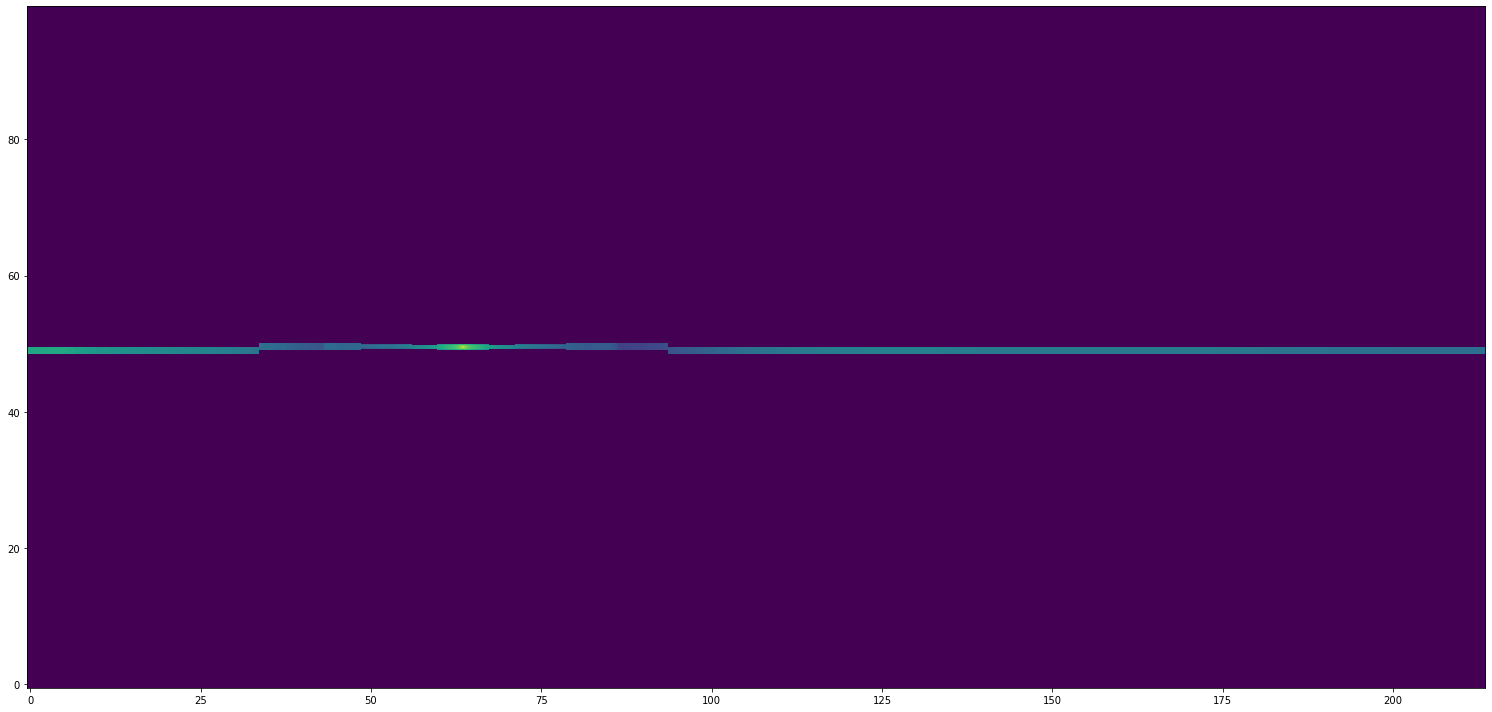

In [13]:
# CASE 2: set dens outside planet surface to 0 --> realistic extinction of CSD + CPD
y_plsurf = int(ori_pl[1])
fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})

dust_dens_2 = set_zero(y_plsurf, size_pl, offset=0.5, fieldname='dust_dens')
im = ax.imshow(dust_dens_2[0][:,:,341].T, origin="lower", norm=LogNorm(vmin=1e-20, vmax=1e-10))
incl_amr(model, dust_dens_2, axis=False)

model.write_file(dust_dens_2, fname='dust_density_2.binp', dir='./')

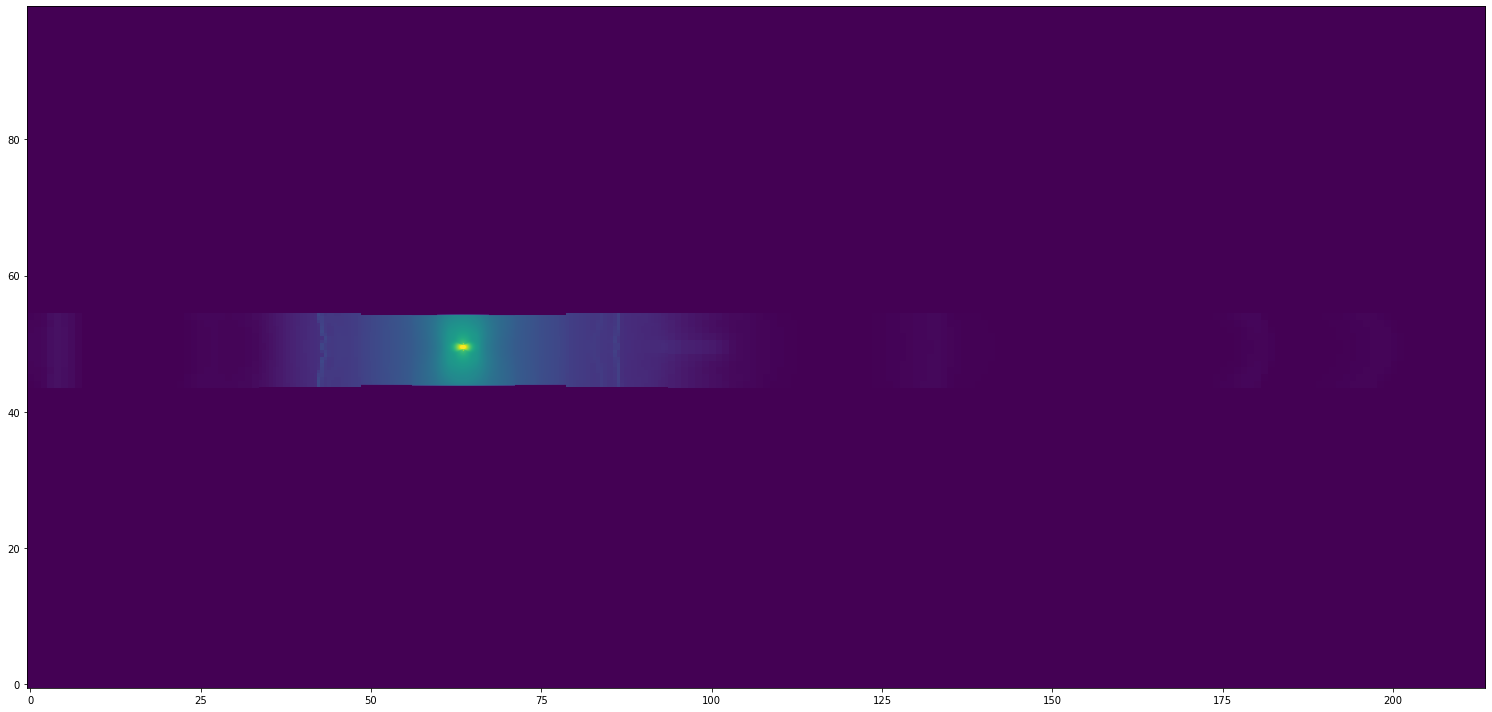

In [15]:
# CASE 3: set temp outside CPD to 0 --> "perfect" extinction of CSD
fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
dust_temp_3 = set_zero(y_CPD, sizey_CPD, fieldname = 'dust_temp')
im = ax.imshow(dust_temp_3[0][:,:,341].T, origin="lower", norm=LogNorm(vmin=10, vmax=1e3))
incl_amr(model, dust_temp_3, vmin=10, vmax=1e3, axis=False)

#model.write_file(dust_temp_3, fname='dust_temperature_3.bdat', dir='./')

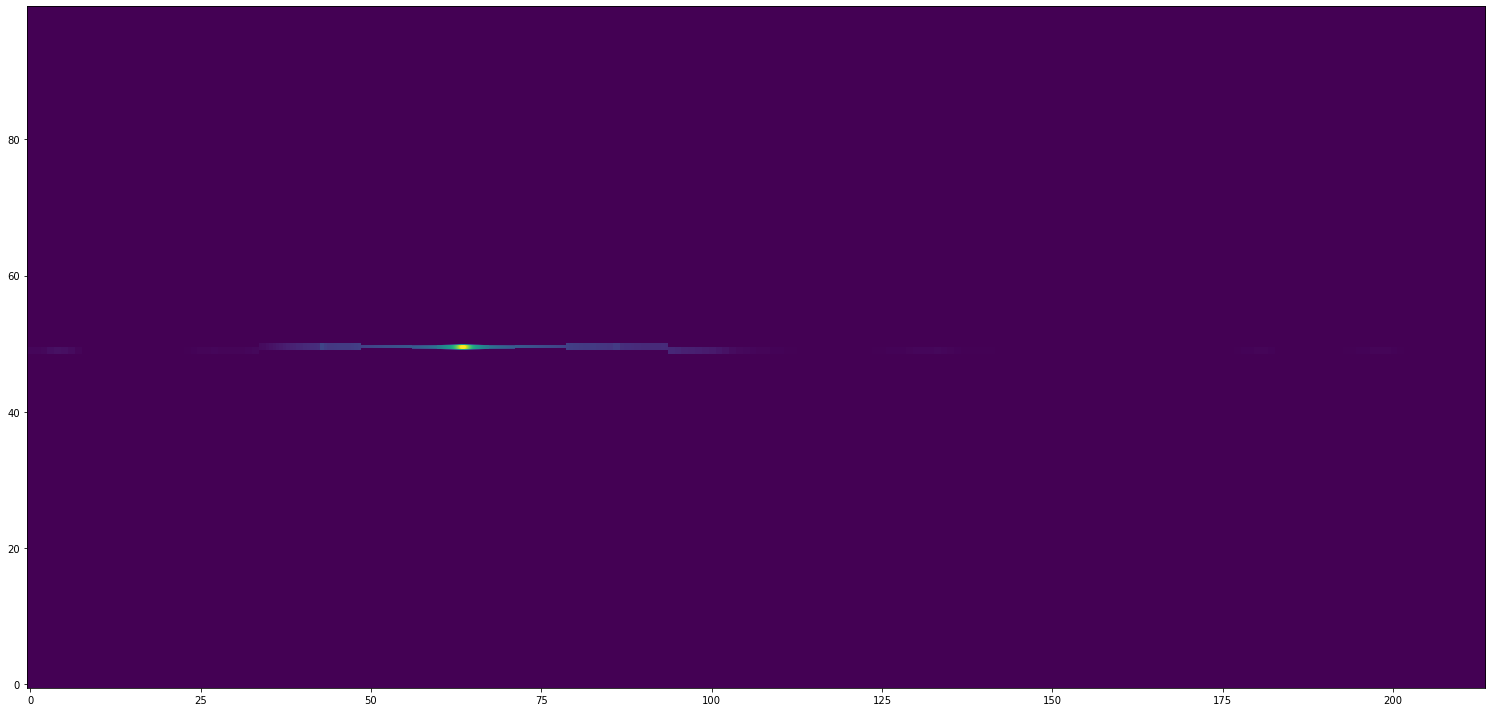

In [16]:
# CASE 4: set dens + temp out planet surface to 0 --> "perfect" extinction of CSD + CPD
fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})

dust_temp_4 = set_zero(y_plsurf, size_pl, offset=0.5, fieldname='dust_temp')
im = ax.imshow(dust_temp_4[0][:,:,341].T, origin="lower", norm=LogNorm(vmin=10, vmax=1e3))
incl_amr(model, dust_temp_4, vmin=10, vmax=1e3, axis=False)

#model.write_file(dust_temp_4, fname='dust_temperature_4.bdat', dir='./')

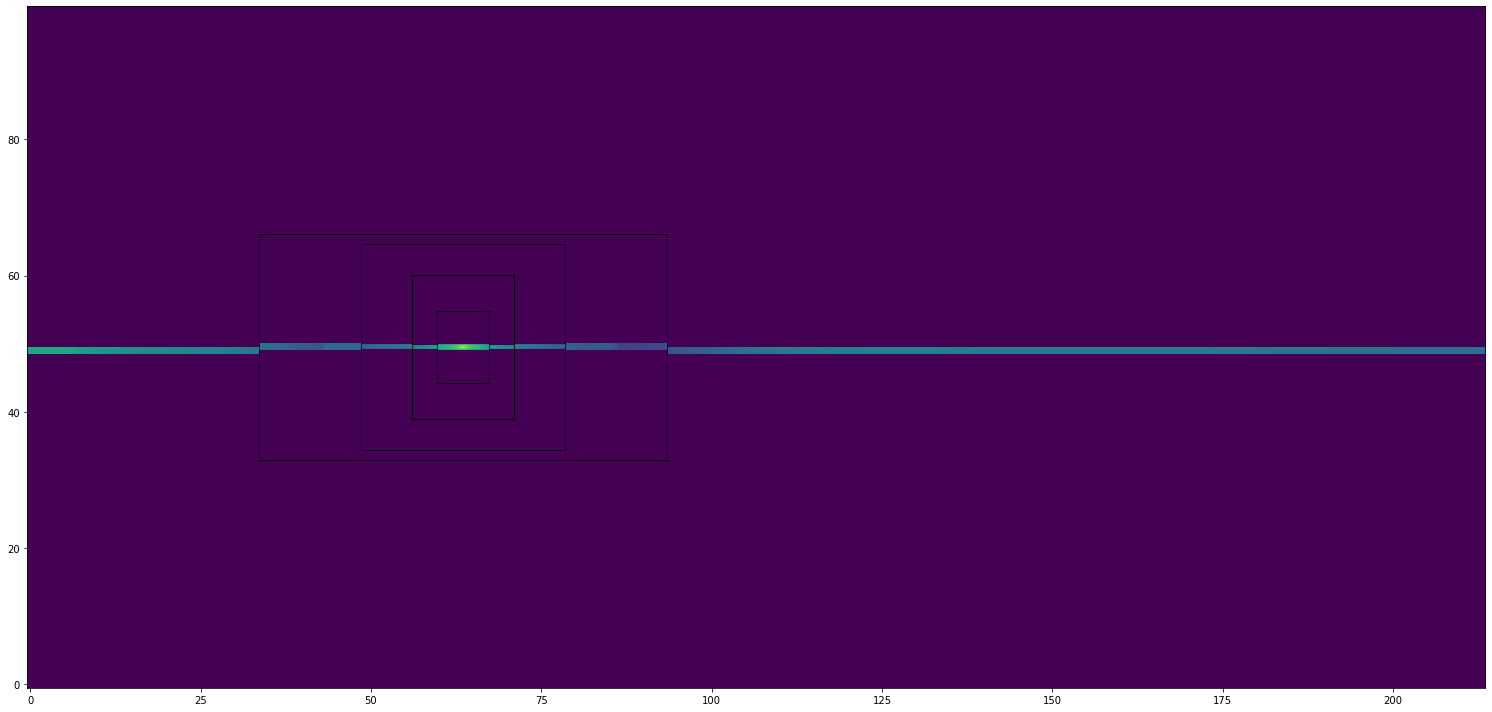

In [80]:
# check new dens
model1 = Radmc3dModel()
model1.read_grid(dir='50au/2/')
model1.read_file('dust_density.binp')
fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
z = int(model1.nz[0]/2) + 1
ax.imshow(model1.dust_dens[0][:,:,z].T, origin="lower", norm=LogNorm(vmin=1e-20, vmax=1e-10))
incl_amr(model1, model1.dust_dens)

### Calculate extinction in cases

In [96]:
# extinction at 2 um
namelist_2 = ["50au/ori/image2_ori.fits", "50au/1/image2_1.fits", "50au/2/image2_2.fits", "50au/3/image2_3.fits", "50au/4/image2_4.fits"]
img_2 = []
hdr_2 = []
for fname in namelist_2:
    with fits.open(fname) as hdulist:
        img_2.append(hdulist[0].data[0])
        hdr_2.append(hdulist[0].header)
print(img_2[0].shape)

(1000, 1000)


0.0 0.07947651097196554
0.0 0.07947651097196554
0.0 0.07947651097196554
0.0 0.07947651097196554
0.0 0.07947651097196554


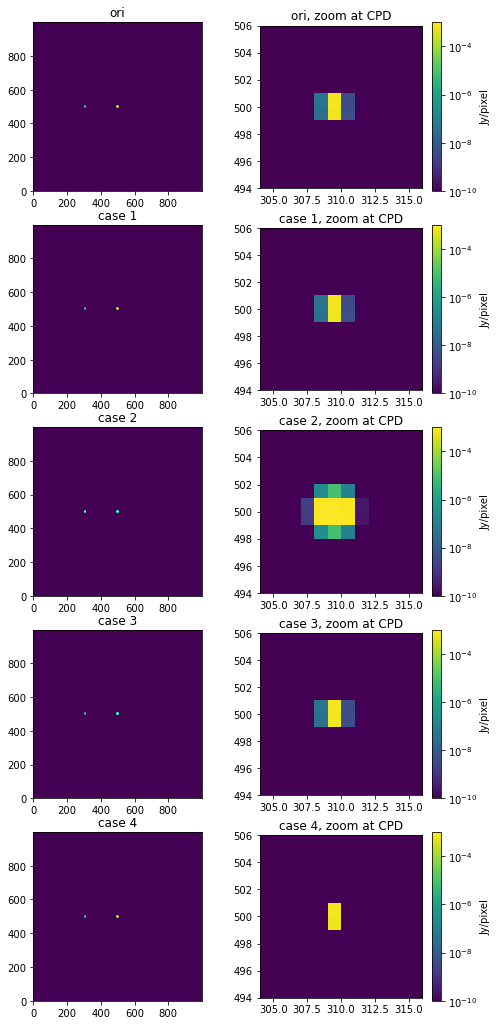

In [97]:
plt.figure(figsize=(8,18))
label=['ori','case 1','case 2','case 3','case 4']
extent = (xmin, xmax, ymin, ymax) = (304, 316, 494, 506)
flux_2 = np.zeros(len(img_2))
for i in range(0,len(img_2)):
    plt.subplot(5,2,2*i+1)
    plt.imshow(img_2[i], norm=LogNorm(vmin=1e-10, vmax=1e-3), origin="lower")
    plt.title(label[i])

    plt.subplot(5,2,2*i+2)
    plt.imshow(img_2[i][ymin:ymax, xmin:xmax], extent=extent, norm=LogNorm(vmin=1e-10, vmax=1e-3), origin="lower")
    flux_2[i] = (img_2[i][ymin:ymax, xmin:xmax].sum())
    plt.title(label[i]+', zoom at CPD')
    plt.colorbar().set_label('Jy/pixel')
    print(img_2[i].min(), img_2[i].max())

In [98]:
# extinction at 10 um
namelist_10 = ["50au/ori/image10_ori.fits", "50au/1/image10_1.fits", "50au/2/image10_2.fits", "50au/3/image10_3.fits", "50au/4/image10_4.fits"]
img_10 = []
hdr_10 = []
for fname in namelist_10:
    with fits.open(fname) as hdulist:
        img_10.append(hdulist[0].data[0])
        hdr_10.append(hdulist[0].header)

0.0 0.07918587878841375
0.0 0.08005069580035908
0.0 0.9693430733629516
0.0 0.07918587875575389
0.0 0.005559744401702856


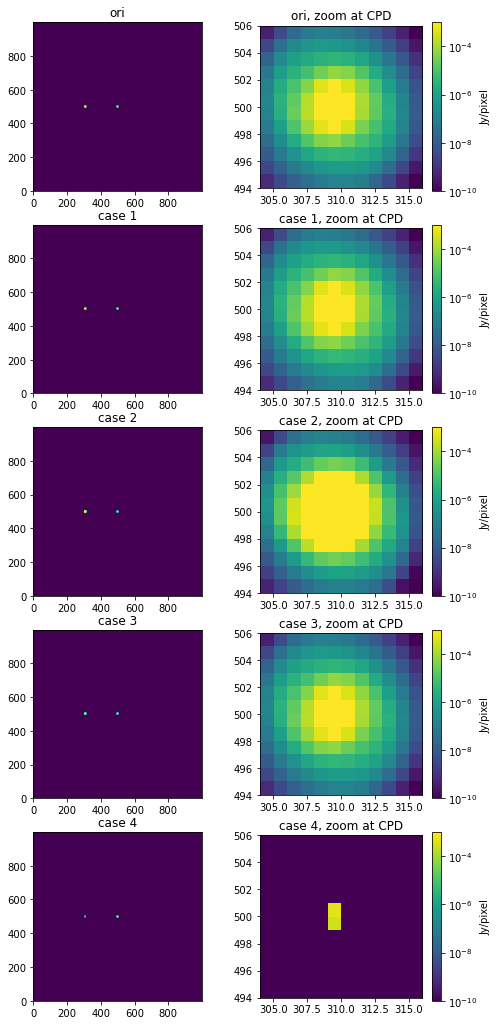

In [99]:
plt.figure(figsize=(8,18))
flux_10 = np.zeros(len(img))
for i in range(0,len(img)):
    plt.subplot(5,2,2*i+1)
    plt.imshow(img_10[i], norm=LogNorm(vmin=1e-10, vmax=1e-3), origin="lower")
    plt.title(label[i])

    plt.subplot(5,2,2*i+2)
    plt.imshow(img_10[i][ymin:ymax, xmin:xmax], extent=extent, norm=LogNorm(vmin=1e-10, vmax=1e-3), origin="lower")
    flux_10[i]=(img_10[i][ymin:ymax, xmin:xmax].sum())
    plt.title(label[i]+', zoom at CPD')
    plt.colorbar().set_label('Jy/pixel')
    print(img_10[i].min(), img_10[i].max())

In [105]:
# flux to magnitude
mag_2 = 2.5 * np.log10(653/flux_2)
mag_10 = 2.5 * np.log10(653/flux_10)

In [106]:
from tabulate import tabulate
labels = ['(mag)','original', 'CSD dens-> 0', 'CSD+CPD dens-> 0', 'CSD temp-> 0', 'CSD+CPD temp-> 0']
line1 = ['2um']+list(mag_2)
line2 = ['10um']+list(mag_10)
table = [labels, line1, line2]
print(tabulate(table))

-----  -----------------  ------------------  -----------------  -----------------  ------------------
(mag)  original           CSD dens-> 0        CSD+CPD dens-> 0   CSD temp-> 0       CSD+CPD temp-> 0
2um    14.10239000269448  14.097764210197944  9.619169497045263  14.10239000269448  14.131911552038186
10um   8.886803565396006  8.8765599939992     5.597134034688798  8.88680358715152   14.73339327764313
-----  -----------------  ------------------  -----------------  -----------------  ------------------
